<a href="https://colab.research.google.com/github/amanichopra/rl-based-artificial-pancreas/blob/main/tx_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split

In [3]:
import sys
from google.colab import drive
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  drive.mount('/content/drive')
  BASE_PATH = 'drive/MyDrive/School/MS/Coursework/Fall 2023/Reinforcement Learning/Project/Data'
else:
  BASE_PATH = '/Users/amanchopra/Documents/School/MS/Fall 2023/RL/Final Project/Data/Processed'

data = pd.read_csv(f"{BASE_PATH}/transition_model_discrete_actions_90_min_history_rewards.csv", index_col=0)
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,BG_t0,BG_t1,BG_t2,BG_t3,BG_t4,BG_t5,BG_t6,BG_t7,BG_t8,BG_t9,...,IOB_t28,IOB_t29,IOB_t30,IOB_t31,IOB_t32,IOB_t33,IOB_t34,IOB_t35,simple_reward,magni_reward
0,127.0,121.0,113.0,99.0,95.0,97.0,101.0,107.0,111.0,118.0,...,0.491872,0.502033,0.510965,0.531246,0.543538,0.555829,0.568121,0.580412,0,-10.211281
1,132.0,127.0,121.0,113.0,99.0,95.0,97.0,101.0,107.0,111.0,...,0.471303,0.491872,0.502033,0.510965,0.531246,0.543538,0.555829,0.568121,0,-12.579462
2,130.0,132.0,127.0,121.0,113.0,99.0,95.0,97.0,101.0,107.0,...,0.469787,0.471303,0.491872,0.502033,0.510965,0.531246,0.543538,0.555829,0,-12.139707
3,120.0,130.0,132.0,127.0,121.0,113.0,99.0,95.0,97.0,101.0,...,0.458479,0.469787,0.471303,0.491872,0.502033,0.510965,0.531246,0.543538,0,-12.800759
4,106.0,120.0,130.0,132.0,127.0,121.0,113.0,99.0,95.0,97.0,...,0.444016,0.458479,0.469787,0.471303,0.491872,0.502033,0.510965,0.531246,0,-14.602987


In [4]:
S = data[[col for col in data.columns if col not in ['InsulinDelivered', 'simple_reward', 'magni_reward'] and 0 <= int(col.split('_')[-1][1:]) <= 17]]
A = data['InsulinDelivered']
S_PRIME = data[[col for col in data.columns if col not in ['InsulinDelivered', 'simple_reward', 'magni_reward'] and 18 <= int(col.split('_')[-1][1:]) <= 35]]

X = pd.concat([S, A], axis=1).values
Y = S_PRIME.values

In [6]:
class Data(Dataset):
    def __init__(self, X, y):
        # convert into PyTorch tensors and remember them
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        # this should return the size of the dataset
        return len(self.X)

    def __getitem__(self, idx):
        # this should return one sample from the dataset
        features = self.X[idx]
        target = self.y[idx]
        return features, target

In [7]:
# Creating a custom Multiple Linear Regression Model
class MultipleLinearRegression(torch.nn.Module):
    # Constructor
    def __init__(self, input_dim, output_dim):
        super(MultipleLinearRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    # Prediction
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

The parameters:  [Parameter containing:
tensor([[-0.1108,  0.1067,  0.0673,  ...,  0.0205, -0.0417,  0.1304],
        [ 0.0656, -0.0896,  0.0372,  ..., -0.1045, -0.1067,  0.0731],
        [ 0.0324,  0.0766, -0.0671,  ..., -0.0236, -0.0104,  0.0275],
        ...,
        [ 0.0997, -0.1329,  0.0149,  ..., -0.0741, -0.0988,  0.0542],
        [ 0.1240, -0.0054, -0.0677,  ..., -0.0465, -0.0255, -0.0052],
        [-0.0933,  0.0516, -0.1142,  ...,  0.0615,  0.1254, -0.0203]],
       requires_grad=True), Parameter containing:
tensor([ 0.0398, -0.0728,  0.0534, -0.0970,  0.0797,  0.0766,  0.0293, -0.0698,
        -0.0879, -0.0085,  0.0946, -0.0909, -0.0865, -0.0806, -0.0411, -0.0529,
        -0.0130, -0.0013, -0.0333,  0.0428,  0.0718,  0.1288,  0.1004,  0.0411,
         0.1015,  0.1019,  0.0582, -0.0622, -0.0836, -0.0727, -0.0300,  0.0464,
         0.1017, -0.0281,  0.0445, -0.0329,  0.0393,  0.0474, -0.1248,  0.0819,
        -0.0332, -0.1177,  0.1272, -0.1313, -0.0224, -0.1186, -0.0450, -0.06

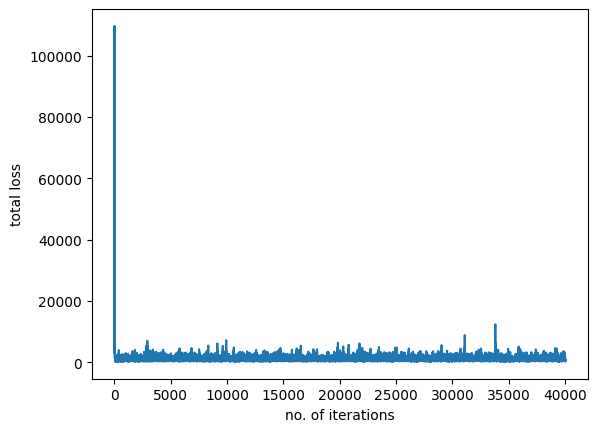

In [11]:
# Creating the model object
MLR_model = MultipleLinearRegression(X.shape[1], Y.shape[1])
print("The parameters: ", list(MLR_model.parameters()))

# Creating dataset object
dataset = Data(X, Y)
trainset, testset = random_split(dataset, [0.7, 0.3])
train_loader = DataLoader(trainset, shuffle=True, batch_size=16)

# defining the model optimizer
optimizer = torch.optim.Adam(MLR_model.parameters(), lr=0.1)
# defining the loss criterion
criterion = torch.nn.MSELoss()


# Train the model
losses = []
epochs = 20
for epoch in range(epochs):
    for x,y in train_loader:
        y_pred = MLR_model(x)
        loss = criterion(y_pred, y)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"epoch = {epoch}, loss = {loss}")
print("Done training!")

# Plot the losses
plt.plot(losses)
plt.xlabel("no. of iterations")
plt.ylabel("total loss")
plt.show()
